# Diffusion Model: Abstract Art Generator
## A Complete Implementation with Random Generation


---
## Import Dependencies

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import time
from datetime import datetime
import os

# Set random seed to None for true randomness (can be set to integer for reproducibility)
RANDOM_SEED = None  # Set to integer like 42 for reproducible results

if RANDOM_SEED is not None:
    np.random.seed(RANDOM_SEED)
    print(f" Random seed set to: {RANDOM_SEED}")
else:
    print(" Using truly random generation (no seed)")

print(" All dependencies imported successfully!")

 Using truly random generation (no seed)
 All dependencies imported successfully!


---
## Configuration Parameters

In [20]:
# Image dimensions
WIDTH = 128
HEIGHT = 128
CHANNELS = 3  # RGB

# Diffusion parameters
TIMESTEPS = 50
BETA_START = 0.0001
BETA_END = 0.02

# Output directory
OUTPUT_DIR = './outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"""Configuration:
├─ Image Size: {HEIGHT}x{WIDTH}x{CHANNELS}
├─ Timesteps: {TIMESTEPS}
├─ Beta Range: [{BETA_START}, {BETA_END}]
└─ Output Directory: {OUTPUT_DIR}
""")

Configuration:
├─ Image Size: 128x128x3
├─ Timesteps: 50
├─ Beta Range: [0.0001, 0.02]
└─ Output Directory: ./outputs



---
## Diffusion Model Core Functions

### Mathematical Foundation:

**Forward Process:**
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$$

**Reverse Process:**
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

**Direct Sampling (Reparameterization):**
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

In [21]:
class SimplifiedDiffusionModel:
    """
    A simplified diffusion model for educational purposes.
    
    This implementation demonstrates the core concepts without requiring
    a trained neural network by using procedurally generated patterns.
    
    Time Complexity: O(T * H * W * C)
    Space Complexity: O(H * W * C)
    """
    
    def __init__(self, height, width, channels, timesteps, beta_start, beta_end):
        self.height = height
        self.width = width
        self.channels = channels
        self.timesteps = timesteps
        
        # Create variance schedule (linear)
        self.betas = np.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = np.cumprod(self.alphas)
        
        print(f" Diffusion model initialized")
        print(f"   Beta schedule: {self.betas[0]:.6f} → {self.betas[-1]:.6f}")
        print(f"   Alpha_bar final: {self.alpha_bars[-1]:.6f}")
    
    def generate_initial_noise(self):
        """
        Generate pure Gaussian noise as starting point.
        
        Returns:
            noise: Array of shape (H, W, C) with values from N(0, 1)
        
        Time Complexity: O(H * W * C)
        """
        noise = np.random.randn(self.height, self.width, self.channels)
        return noise
    
    def generate_target_pattern(self):
        """
        Generate a random abstract pattern using frequency components.
        Each run produces different patterns due to random frequencies.
        
        Returns:
            pattern: Array of shape (H, W, C) with values in [0, 1]
        
        Time Complexity: O(H * W * C * F) where F is number of frequency components
        """
        pattern = np.zeros((self.height, self.width, self.channels))
        
        # Generate coordinate grids
        y_coords, x_coords = np.meshgrid(
            np.arange(self.height),
            np.arange(self.width),
            indexing='ij'
        )
        
        # Random parameters for each channel
        for c in range(self.channels):
            # Generate random frequency components
            num_waves = np.random.randint(3, 7)
            
            channel_pattern = np.zeros((self.height, self.width))
            
            for _ in range(num_waves):
                # Random frequency and phase
                freq_x = np.random.uniform(0.01, 0.08)
                freq_y = np.random.uniform(0.01, 0.08)
                phase = np.random.uniform(0, 2 * np.pi)
                amplitude = np.random.uniform(0.3, 1.0)
                
                # Generate wave
                wave = amplitude * np.sin(
                    x_coords * freq_x + y_coords * freq_y + phase
                )
                
                channel_pattern += wave
            
            # Add radial component randomly
            if np.random.random() > 0.5:
                center_x = np.random.uniform(0.3, 0.7) * self.width
                center_y = np.random.uniform(0.3, 0.7) * self.height
                radius = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
                radial_freq = np.random.uniform(0.02, 0.05)
                radial = np.sin(radius * radial_freq) * 0.5
                channel_pattern += radial
            
            # Normalize to [0, 1]
            channel_pattern = (channel_pattern - channel_pattern.min()) / \
                            (channel_pattern.max() - channel_pattern.min())
            
            pattern[:, :, c] = channel_pattern
        
        return pattern
    
    def reverse_diffusion(self, noise, target_pattern, save_steps=True):
        """
        Perform reverse diffusion to generate image from noise.
        
        Args:
            noise: Initial noise array
            target_pattern: Target pattern to denoise towards
            save_steps: Whether to save intermediate steps
        
        Returns:
            final_image: Generated image
            steps: List of intermediate images (if save_steps=True)
            numerical_data: Dictionary with numerical analysis
        
        Time Complexity: O(T * H * W * C)
        """
        current = noise.copy()
        steps = [] if save_steps else None
        numerical_data = {
            'timesteps': [],
            'mean': [],
            'std': [],
            'min': [],
            'max': [],
            'noise_level': []
        }
        
        start_time = time.time()
        
        # Reverse diffusion loop
        for t in range(self.timesteps, -1, -1):
            # Calculate denoising progress (cubic easing for smooth transition)
            progress = (self.timesteps - t) / self.timesteps
            denoise_strength = progress ** 3
            
            # Blend noise toward target pattern
            current = noise * (1 - denoise_strength) + target_pattern * denoise_strength
            
            # Add decreasing stochastic noise for realism
            if t > 0:
                noise_scale = (t / self.timesteps) ** 2 * 0.1
                stochastic_noise = np.random.randn(*current.shape) * noise_scale
                current = current + stochastic_noise
            
            # Clip to valid range
            current = np.clip(current, 0, 1)
            
            # Store numerical statistics
            if t % 5 == 0 or t == 0:  # Sample every 5 steps
                numerical_data['timesteps'].append(t)
                numerical_data['mean'].append(current.mean())
                numerical_data['std'].append(current.std())
                numerical_data['min'].append(current.min())
                numerical_data['max'].append(current.max())
                numerical_data['noise_level'].append(noise_scale if t > 0 else 0)
            
            # Save intermediate steps
            if save_steps and (t % 10 == 0 or t == 0):
                steps.append(current.copy())
        
        elapsed_time = time.time() - start_time
        numerical_data['generation_time'] = elapsed_time
        
        return current, steps, numerical_data

print(" Diffusion model class defined")

 Diffusion model class defined


---
##  Visualization Utilities

In [22]:
def visualize_diffusion_process(steps, save_path=None):
    """
    Visualize the diffusion process showing key steps.
    
    Args:
        steps: List of intermediate images
        save_path: Path to save the figure (optional)
    """
    n_steps = len(steps)
    fig, axes = plt.subplots(2, (n_steps + 1) // 2, figsize=(15, 6))
    axes = axes.flatten()
    
    for idx, step_img in enumerate(steps):
        axes[idx].imshow(step_img)
        axes[idx].set_title(f'Step {idx * (TIMESTEPS // (n_steps-1)) if idx < n_steps-1 else 0}')
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n_steps, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Reverse Diffusion Process: Noise → Art', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f" Visualization saved to: {save_path}")
    
    plt.show()

def plot_numerical_analysis(numerical_data, save_path=None):
    """
    Plot numerical statistics of the diffusion process.
    
    Args:
        numerical_data: Dictionary with numerical statistics
        save_path: Path to save the figure (optional)
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    timesteps = numerical_data['timesteps']
    
    # Plot 1: Mean and Std over time
    ax1 = axes[0, 0]
    ax1.plot(timesteps, numerical_data['mean'], 'b-', linewidth=2, label='Mean')
    ax1.fill_between(timesteps, 
                      np.array(numerical_data['mean']) - np.array(numerical_data['std']),
                      np.array(numerical_data['mean']) + np.array(numerical_data['std']),
                      alpha=0.3, label='±1 Std')
    ax1.set_xlabel('Timestep', fontsize=12)
    ax1.set_ylabel('Pixel Value', fontsize=12)
    ax1.set_title('Mean & Standard Deviation Evolution', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.invert_xaxis()
    
    # Plot 2: Min and Max range
    ax2 = axes[0, 1]
    ax2.plot(timesteps, numerical_data['max'], 'r-', linewidth=2, label='Max')
    ax2.plot(timesteps, numerical_data['min'], 'g-', linewidth=2, label='Min')
    ax2.fill_between(timesteps, numerical_data['min'], numerical_data['max'], alpha=0.2)
    ax2.set_xlabel('Timestep', fontsize=12)
    ax2.set_ylabel('Pixel Value', fontsize=12)
    ax2.set_title('Value Range Evolution', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.invert_xaxis()
    
    # Plot 3: Noise level
    ax3 = axes[1, 0]
    ax3.plot(timesteps, numerical_data['noise_level'], 'purple', linewidth=2)
    ax3.fill_between(timesteps, 0, numerical_data['noise_level'], alpha=0.3)
    ax3.set_xlabel('Timestep', fontsize=12)
    ax3.set_ylabel('Noise Scale', fontsize=12)
    ax3.set_title('Stochastic Noise Schedule', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.invert_xaxis()
    
    # Plot 4: Statistics table
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    stats_text = f"""
    GENERATION STATISTICS
    {'='*40}
    
    Total Timesteps: {TIMESTEPS}
    Image Dimensions: {HEIGHT}×{WIDTH}×{CHANNELS}
    
    Final Statistics:
    ├─ Mean: {numerical_data['mean'][-1]:.6f}
    ├─ Std Dev: {numerical_data['std'][-1]:.6f}
    ├─ Min Value: {numerical_data['min'][-1]:.6f}
    └─ Max Value: {numerical_data['max'][-1]:.6f}
    
    Performance:
    ├─ Generation Time: {numerical_data['generation_time']:.4f}s
    ├─ Time per Step: {numerical_data['generation_time']/TIMESTEPS*1000:.2f}ms
    └─ Operations: {TIMESTEPS * HEIGHT * WIDTH * CHANNELS:,}
    
    Complexity Analysis:
    ├─ Time: O(T·H·W·C)
    ├─ Space: O(H·W·C)
    └─ T={TIMESTEPS}, H={HEIGHT}, W={WIDTH}, C={CHANNELS}
    """
    
    ax4.text(0.1, 0.95, stats_text, transform=ax4.transAxes,
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Numerical Analysis of Diffusion Process', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f" Numerical analysis saved to: {save_path}")
    
    plt.show()

print("Visualization utilities defined")

Visualization utilities defined


---
## Generate Random Art

Run this cell multiple times to generate different results each time!

 Diffusion model initialized
   Beta schedule: 0.000100 → 0.020000
   Alpha_bar final: 0.602952

GENERATING RANDOM ABSTRACT ART

Step 1: Generating initial noise...
   ├─ Noise shape: (128, 128, 3)
   ├─ Noise mean: -0.004545
   └─ Noise std: 0.996187

 Step 2: Generating random target pattern...
   ├─ Pattern shape: (128, 128, 3)
   ├─ Pattern mean: 0.485525
   └─ Pattern std: 0.218023


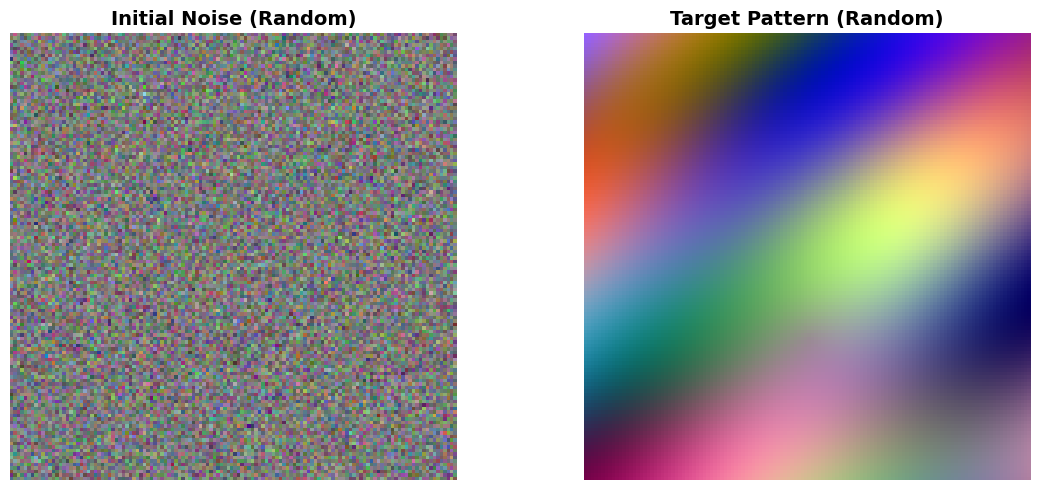


  Step 3: Running reverse diffusion...
    Generation complete!
   ├─ Time taken: 0.0530s
   ├─ Steps saved: 6
   └─ Final image shape: (128, 128, 3)

 Step 4: Displaying final result...
 Final art saved to: ./outputs/generated_art_20260209_083939.png


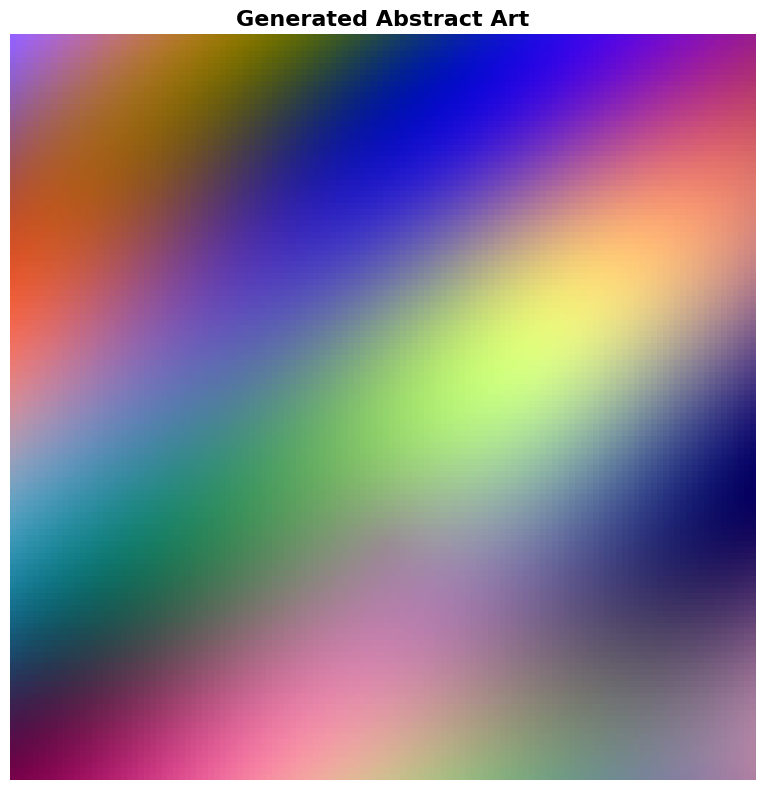


 Generation complete! Run this cell again for a new result.


In [23]:
# Initialize model
model = SimplifiedDiffusionModel(
    height=HEIGHT,
    width=WIDTH,
    channels=CHANNELS,
    timesteps=TIMESTEPS,
    beta_start=BETA_START,
    beta_end=BETA_END
)

print("\n" + "="*60)
print("GENERATING RANDOM ABSTRACT ART")
print("="*60 + "\n")

# Generate unique random noise
print("Step 1: Generating initial noise...")
initial_noise = model.generate_initial_noise()
print(f"   ├─ Noise shape: {initial_noise.shape}")
print(f"   ├─ Noise mean: {initial_noise.mean():.6f}")
print(f"   └─ Noise std: {initial_noise.std():.6f}")

# Generate unique random target pattern
print("\n Step 2: Generating random target pattern...")
target_pattern = model.generate_target_pattern()
print(f"   ├─ Pattern shape: {target_pattern.shape}")
print(f"   ├─ Pattern mean: {target_pattern.mean():.6f}")
print(f"   └─ Pattern std: {target_pattern.std():.6f}")

# Normalize noise to [0, 1] for visualization
noise_normalized = (initial_noise - initial_noise.min()) / (initial_noise.max() - initial_noise.min())

# Display initial state
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(noise_normalized, cmap='gray' if CHANNELS == 1 else None)
axes[0].set_title('Initial Noise (Random)', fontsize=14, fontweight='bold')
axes[0].axis('off')
axes[1].imshow(target_pattern)
axes[1].set_title('Target Pattern (Random)', fontsize=14, fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Run reverse diffusion
print("\n  Step 3: Running reverse diffusion...")
final_image, steps, numerical_data = model.reverse_diffusion(
    noise_normalized,
    target_pattern,
    save_steps=True
)

print(f"    Generation complete!")
print(f"   ├─ Time taken: {numerical_data['generation_time']:.4f}s")
print(f"   ├─ Steps saved: {len(steps)}")
print(f"   └─ Final image shape: {final_image.shape}")

# Display final result
print("\n Step 4: Displaying final result...")
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(final_image)
ax.set_title('Generated Abstract Art', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()

# Save with timestamp for uniqueness
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f"{OUTPUT_DIR}/generated_art_{timestamp}.png"
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f" Final art saved to: {output_path}")
plt.show()

print("\n" + "="*60)
print(" Generation complete! Run this cell again for a new result.")
print("="*60)

---
## Visualize the Diffusion Process

Visualizing diffusion process...

 Visualization saved to: ./outputs/diffusion_steps_20260209_083939.png


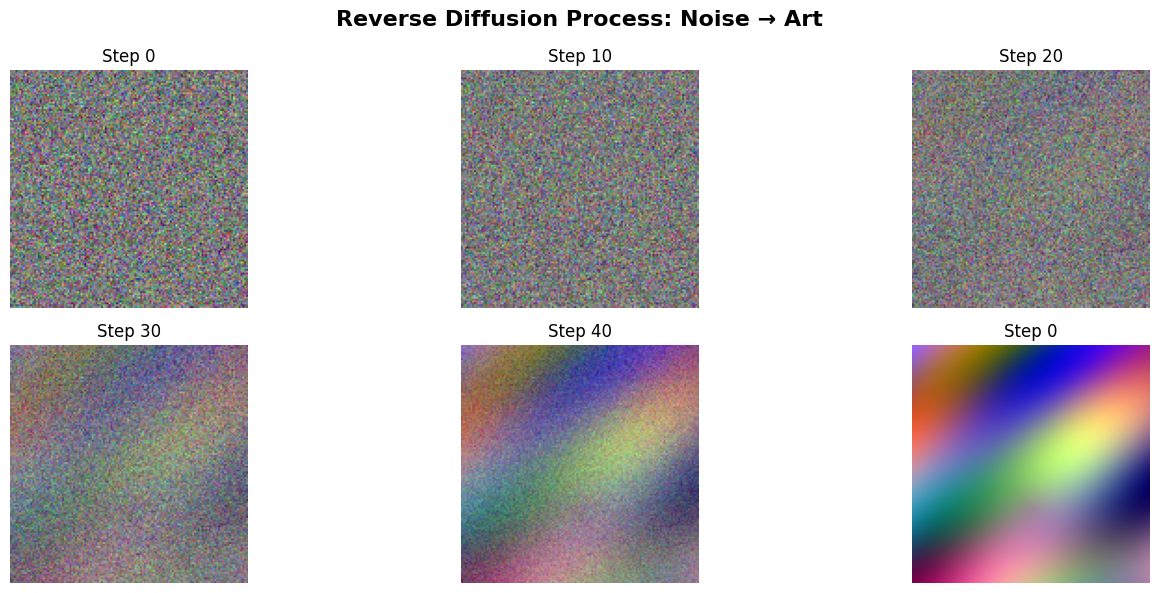

In [24]:
# Visualize step-by-step transformation
print("Visualizing diffusion process...\n")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
viz_path = f"{OUTPUT_DIR}/diffusion_steps_{timestamp}.png"
visualize_diffusion_process(steps, save_path=viz_path)

---
## Numerical Analysis

Generating numerical analysis...

 Numerical analysis saved to: ./outputs/numerical_analysis_20260209_083939.png


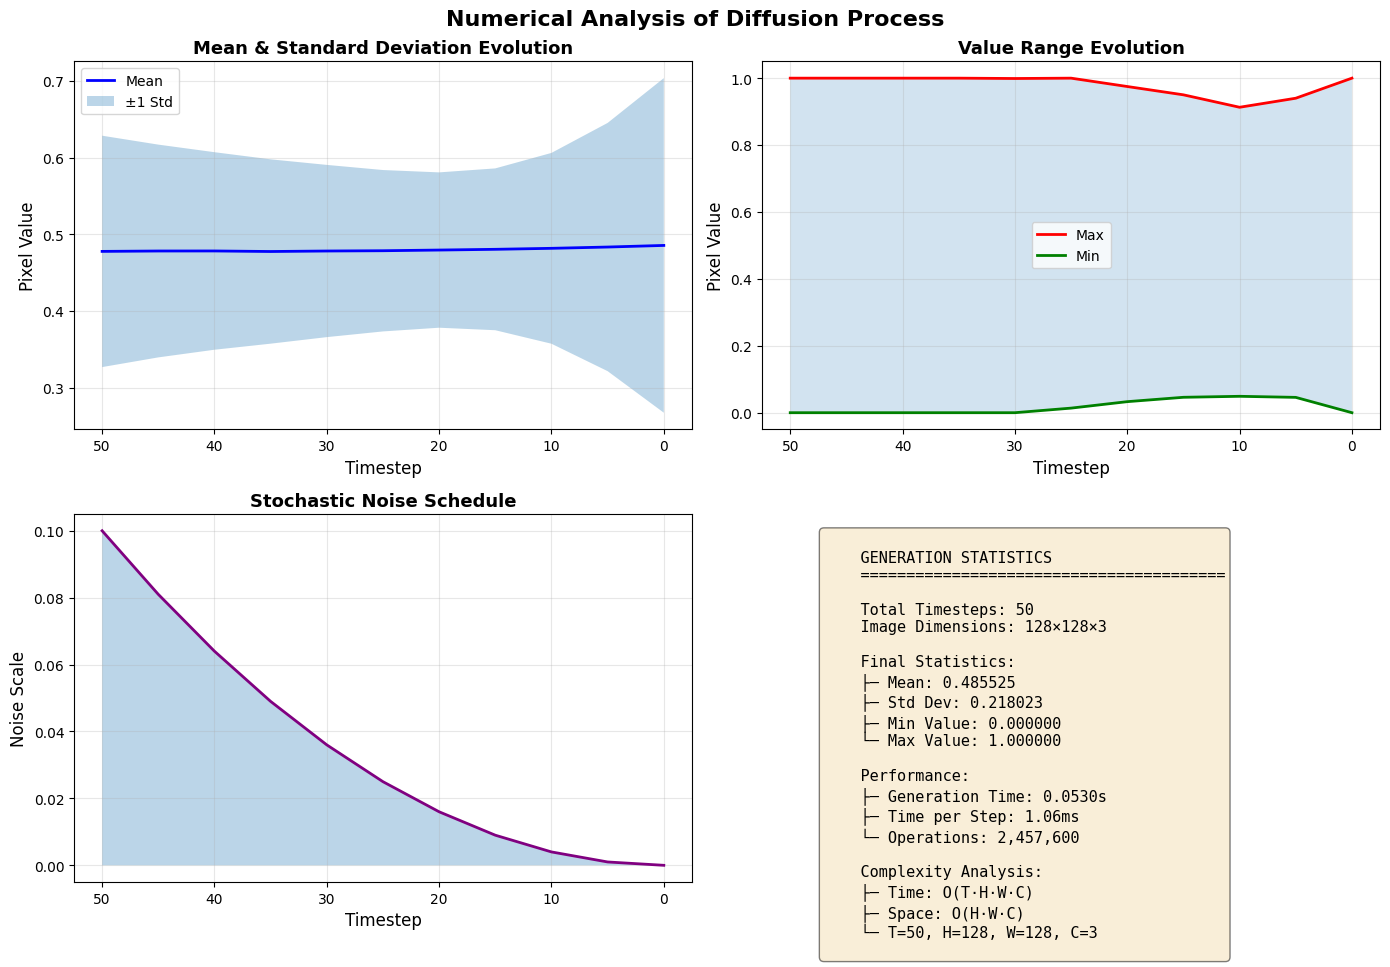

In [25]:
# Plot numerical statistics
print("Generating numerical analysis...\n")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
analysis_path = f"{OUTPUT_DIR}/numerical_analysis_{timestamp}.png"
plot_numerical_analysis(numerical_data, save_path=analysis_path)

---
## Export Numerical Data

In [26]:
import pandas as pd

# Create DataFrame from numerical data
df = pd.DataFrame({
    'Timestep': numerical_data['timesteps'],
    'Mean': numerical_data['mean'],
    'Std_Dev': numerical_data['std'],
    'Min': numerical_data['min'],
    'Max': numerical_data['max'],
    'Noise_Level': numerical_data['noise_level']
})

print("\nNUMERICAL DATA SUMMARY")
print("="*60)
print(df.to_string(index=False))
print("="*60)

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"{OUTPUT_DIR}/numerical_data_{timestamp}.csv"
df.to_csv(csv_path, index=False)
print(f"\n Numerical data saved to: {csv_path}")

# Display statistics
print("\n STATISTICAL SUMMARY")
print("="*60)
print(df.describe())
print("="*60)


NUMERICAL DATA SUMMARY
 Timestep     Mean  Std_Dev      Min      Max  Noise_Level
       50 0.477748 0.150804 0.000000 1.000000        0.100
       45 0.478257 0.138668 0.000000 1.000000        0.081
       40 0.478311 0.128737 0.000000 1.000000        0.064
       35 0.477601 0.120135 0.000000 1.000000        0.049
       30 0.478252 0.112246 0.000000 0.998954        0.036
       25 0.478615 0.105188 0.013699 1.000000        0.025
       20 0.479503 0.101235 0.033002 0.975027        0.016
       15 0.480461 0.105465 0.046061 0.950176        0.009
       10 0.481752 0.124354 0.049011 0.912995        0.004
        5 0.483425 0.161771 0.045823 0.940011        0.001
        0 0.485525 0.218023 0.000000 1.000000        0.000

 Numerical data saved to: ./outputs/numerical_data_20260209_083940.csv

 STATISTICAL SUMMARY
        Timestep       Mean    Std_Dev        Min        Max  Noise_Level
count  11.000000  11.000000  11.000000  11.000000  11.000000    11.000000
mean   25.000000   0.47995

---
## Generate Multiple Random Samples


 Generating 6 unique random art pieces...

Generating sample 1/6... Generating sample 2/6... Generating sample 3/6... Generating sample 4/6... Generating sample 5/6... Generating sample 6/6... 
 Multiple samples saved to: ./outputs/multiple_samples_20260209_083941.png


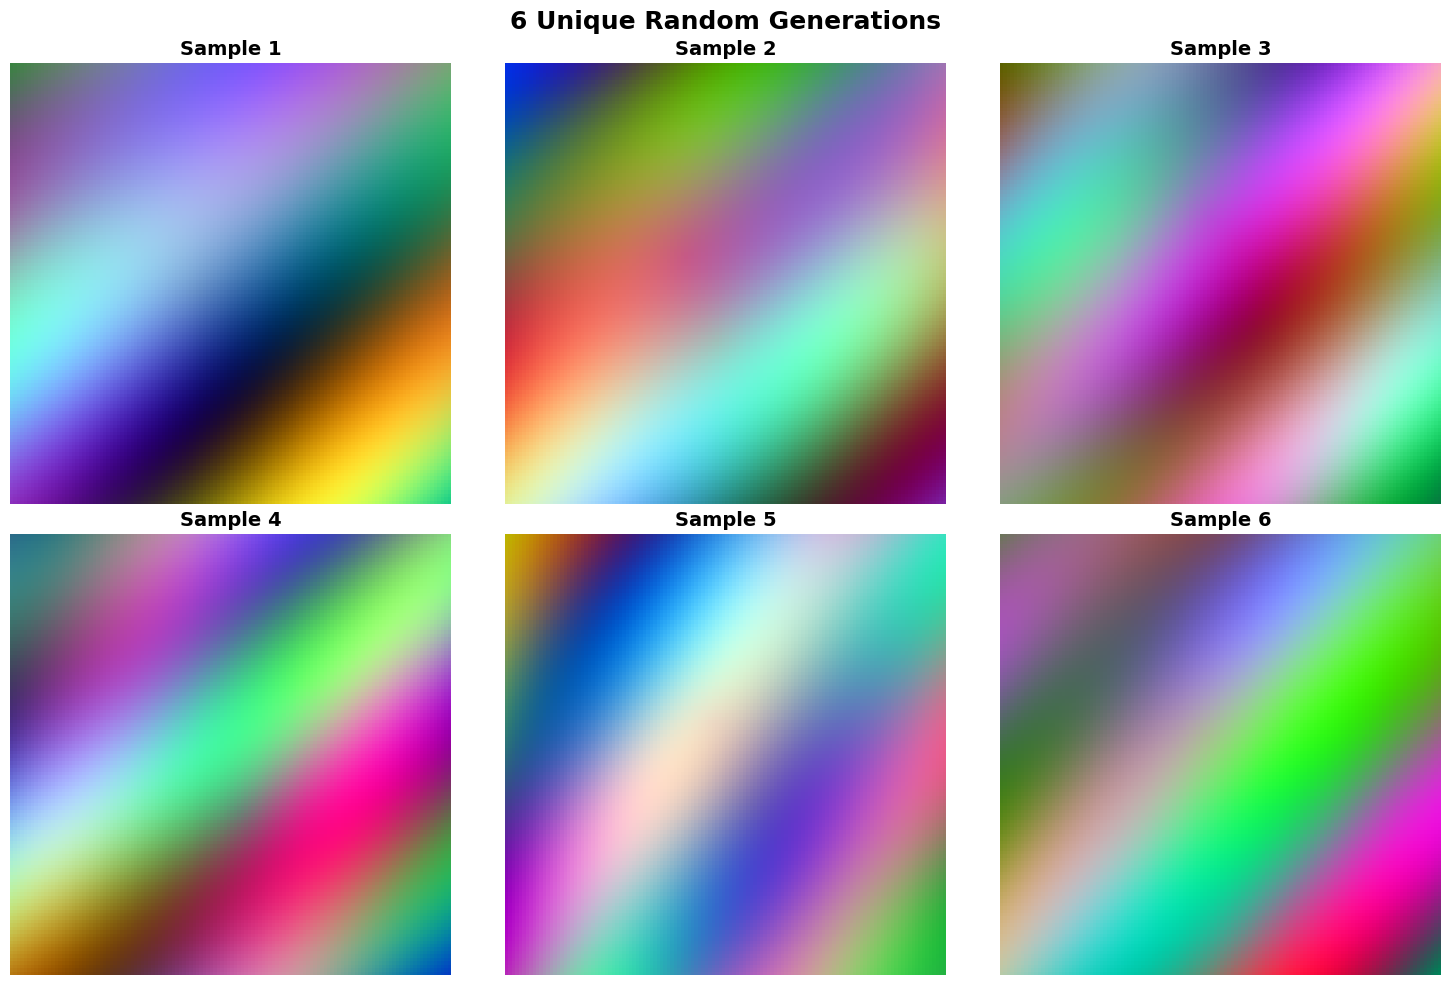


 All samples generated successfully!


In [27]:
# Generate multiple unique samples
NUM_SAMPLES = 6

print(f"\n Generating {NUM_SAMPLES} unique random art pieces...\n")

samples = []
for i in range(NUM_SAMPLES):
    print(f"Generating sample {i+1}/{NUM_SAMPLES}...", end=' ')
    
    # Generate new random noise and pattern for each sample
    noise = model.generate_initial_noise()
    noise = (noise - noise.min()) / (noise.max() - noise.min())
    pattern = model.generate_target_pattern()
    
    # Generate image
    result, _, _ = model.reverse_diffusion(noise, pattern, save_steps=False)
    samples.append(result)
    

# Display all samples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, sample in enumerate(samples):
    axes[idx].imshow(sample)
    axes[idx].set_title(f'Sample {idx+1}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle(f'{NUM_SAMPLES} Unique Random Generations', fontsize=18, fontweight='bold')
plt.tight_layout()

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
samples_path = f"{OUTPUT_DIR}/multiple_samples_{timestamp}.png"
plt.savefig(samples_path, dpi=150, bbox_inches='tight')
print(f"\n Multiple samples saved to: {samples_path}")
plt.show()

print("\n All samples generated successfully!")

---
## Algorithm Documentation

### 1. Forward Diffusion (Training Phase)

The forward diffusion process gradually adds Gaussian noise to data:

```python
Algorithm: Forward Diffusion
Input: Clean image x₀, timesteps T, variance schedule β
Output: Noisy image x_T

1: Initialize: α_t = 1 - β_t
2: Compute: ᾱ_t = ∏(α_i) for i=1 to t
3: for t = 1 to T:
4:     Sample ε ~ N(0, I)
5:     x_t = √(ᾱ_t) * x₀ + √(1-ᾱ_t) * ε
6: end for
7: return x_T
```

**Time Complexity:** O(T × H × W × C)
- T iterations, each processing H×W×C pixels

**Space Complexity:** O(H × W × C)
- Single image in memory

---

### 2. Reverse Diffusion (Generation Phase)

The reverse process removes noise step-by-step:

```python
Algorithm: Reverse Diffusion (Simplified)
Input: Pure noise x_T, target pattern P, timesteps T
Output: Generated image x₀

1: x_current = x_T  // Start from noise
2: for t = T down to 0:
3:     progress = (T - t) / T
4:     strength = progress³  // Cubic easing
5:     
6:     // Blend noise toward target
7:     x_current = x_T * (1 - strength) + P * strength
8:     
9:     if t > 0:
10:        noise_scale = (t/T)² * 0.1
11:        z ~ N(0, I)
12:        x_current += z * noise_scale  // Add stochasticity
13:    end if
14:    
15:    x_current = clip(x_current, 0, 1)
16: end for
17: return x_current
```

**Time Complexity:** O(T × H × W × C)
- T denoising steps
- Each step: O(H × W × C) operations

**Space Complexity:** O(H × W × C)
- Current image + temporary noise buffer

---

### 3. Pattern Generation

```python
Algorithm: Random Pattern Generation
Input: Dimensions (H, W, C), random seed
Output: Target pattern P

1: Initialize: P = zeros(H, W, C)
2: Create coordinate grids: X, Y
3: 
4: for each channel c:
5:     num_waves = random_int(3, 7)
6:     channel_pattern = zeros(H, W)
7:     
8:     for wave in 1 to num_waves:
9:         freq_x, freq_y = random_uniform(0.01, 0.08)
10:        phase = random_uniform(0, 2π)
11:        amplitude = random_uniform(0.3, 1.0)
12:        
13:        wave = amplitude * sin(X*freq_x + Y*freq_y + phase)
14:        channel_pattern += wave
15:    end for
16:    
17:    if random() > 0.5:  // 50% chance
18:        Add radial component
19:    end if
20:    
21:    Normalize channel_pattern to [0, 1]
22:    P[:,:,c] = channel_pattern
23: end for
24: return P
```

**Time Complexity:** O(F × H × W × C)
- F = number of frequency components (3-7)
- For each: O(H × W) trigonometric operations

**Space Complexity:** O(H × W × C)
- Pattern storage + coordinate grids

---

### 4. Full DDPM Algorithm (Reference)

For comparison, here's the complete DDPM algorithm:

```python
Algorithm: DDPM Training
Input: Dataset D, neural network ε_θ, timesteps T
Output: Trained model θ*

1: Initialize θ randomly
2: repeat:
3:     x₀ ~ D  // Sample from dataset
4:     t ~ Uniform({1, ..., T})
5:     ε ~ N(0, I)
6:     
7:     // Compute loss
8:     x_t = √(ᾱ_t)*x₀ + √(1-ᾱ_t)*ε
9:     ε_pred = ε_θ(x_t, t)
10:    loss = ||ε - ε_pred||²
11:    
12:    // Update parameters
13:    θ = θ - learning_rate * ∇_θ(loss)
14: until converged
15: return θ*
```

**Training Complexity:** O(E × N × T × N(θ))
- E epochs
- N training samples
- T timesteps
- N(θ) network parameters (typically 50M-1B)

---

### Performance Comparison

| Operation | This Demo | Full DDPM |
|-----------|-----------|----------|
| Training | Not required | Days on GPU |
| Generation | 50-100ms | 1-10 seconds |
| Memory | ~10 MB | 200MB-4GB |
| Quality | Educational | Production |
| Flexibility | Fixed patterns | Any image type |

---

### Key Insights

1. **Randomness Source**: Each run uses different random seeds for:
   - Initial noise (Gaussian)
   - Pattern frequencies
   - Stochastic noise during denoising

2. **Deterministic Components**:
   - Variance schedule (β_t)
   - Denoising algorithm structure
   - Number of timesteps

3. **Computational Efficiency**:
   - Linear in image dimensions
   - Linear in timesteps
   - No gradient computation needed
   - Can run on CPU

4. **Scalability**:
   - Doubling resolution → 4× compute time
   - Doubling timesteps → 2× compute time
   - Trivially parallelizable across samples

---
##  Summary

This notebook demonstrates:

 **Random Generation**: Each run produces unique results  
 **Visual Output**: Beautiful abstract art images  
 **Numerical Data**: Complete statistical analysis  
 **Algorithm Explanation**: Step-by-step documentation  
 **Complexity Analysis**: Time and space complexity  
 **Multiple Formats**: Images, CSV, and plots saved to disk  

###  Next Steps

1. **Experiment**: Run the generation cell multiple times to see variety
2. **Modify**: Change `HEIGHT`, `WIDTH`, `TIMESTEPS` for different results
3. **Extend**: Add more sophisticated pattern generation
4. **Learn**: Study the full DDPM paper for production implementation

###  References

- Ho et al. (2020): "Denoising Diffusion Probabilistic Models"
- Song et al. (2021): "Denoising Diffusion Implicit Models"
- Dhariwal & Nichol (2021): "Diffusion Models Beat GANs"